In [187]:
# 데이터 불러오기
import pandas as pd

with open("data/k-league-data-20240604-1021-merged.csv", mode='r') as file:
    data = pd.read_csv(file)
    df = pd.DataFrame(data)

         슈팅     유효 슈팅    PA내 슈팅    PA외 슈팅     오프사이드    드리블 시도       키패스  \
0  1.631279  0.699120  1.071983  0.559296  0.093216  1.025375  0.745728   
1  3.308824  0.661765  1.323529  1.985294  0.000000  2.647059  0.661765   
2  3.075671  0.878763  2.123678  0.951993  0.512612  0.512612  0.878763   
5  0.590994  0.168856  0.506567  0.084428  0.253283  0.253283  0.506567   
6  0.794118  0.264706  0.397059  0.397059  0.000000  0.397059  0.000000   

    전방 패스 시도   후방 패스 시도     횡패스 시도  ...  경합 공중 시도     태클 시도      클리어링  \
0   5.546349   6.664940   6.338685  ...  4.381150  2.377007  0.932160   
1   5.955882   7.279412   2.647059  ...  2.647059  2.647059  0.661765   
2   4.247356   7.542718   5.052889  ...  4.393816  1.025224  0.732303   
5  13.339587  14.352720   9.540338  ...  1.688555  1.688555  1.350844   
6  12.970588  11.514706  17.073529  ...  3.176471  1.720588  0.529412   

       인터셉트        차단        획득        블락       볼미스        파울       피파울  
0  0.559296  1.211807  4.800621  1.2

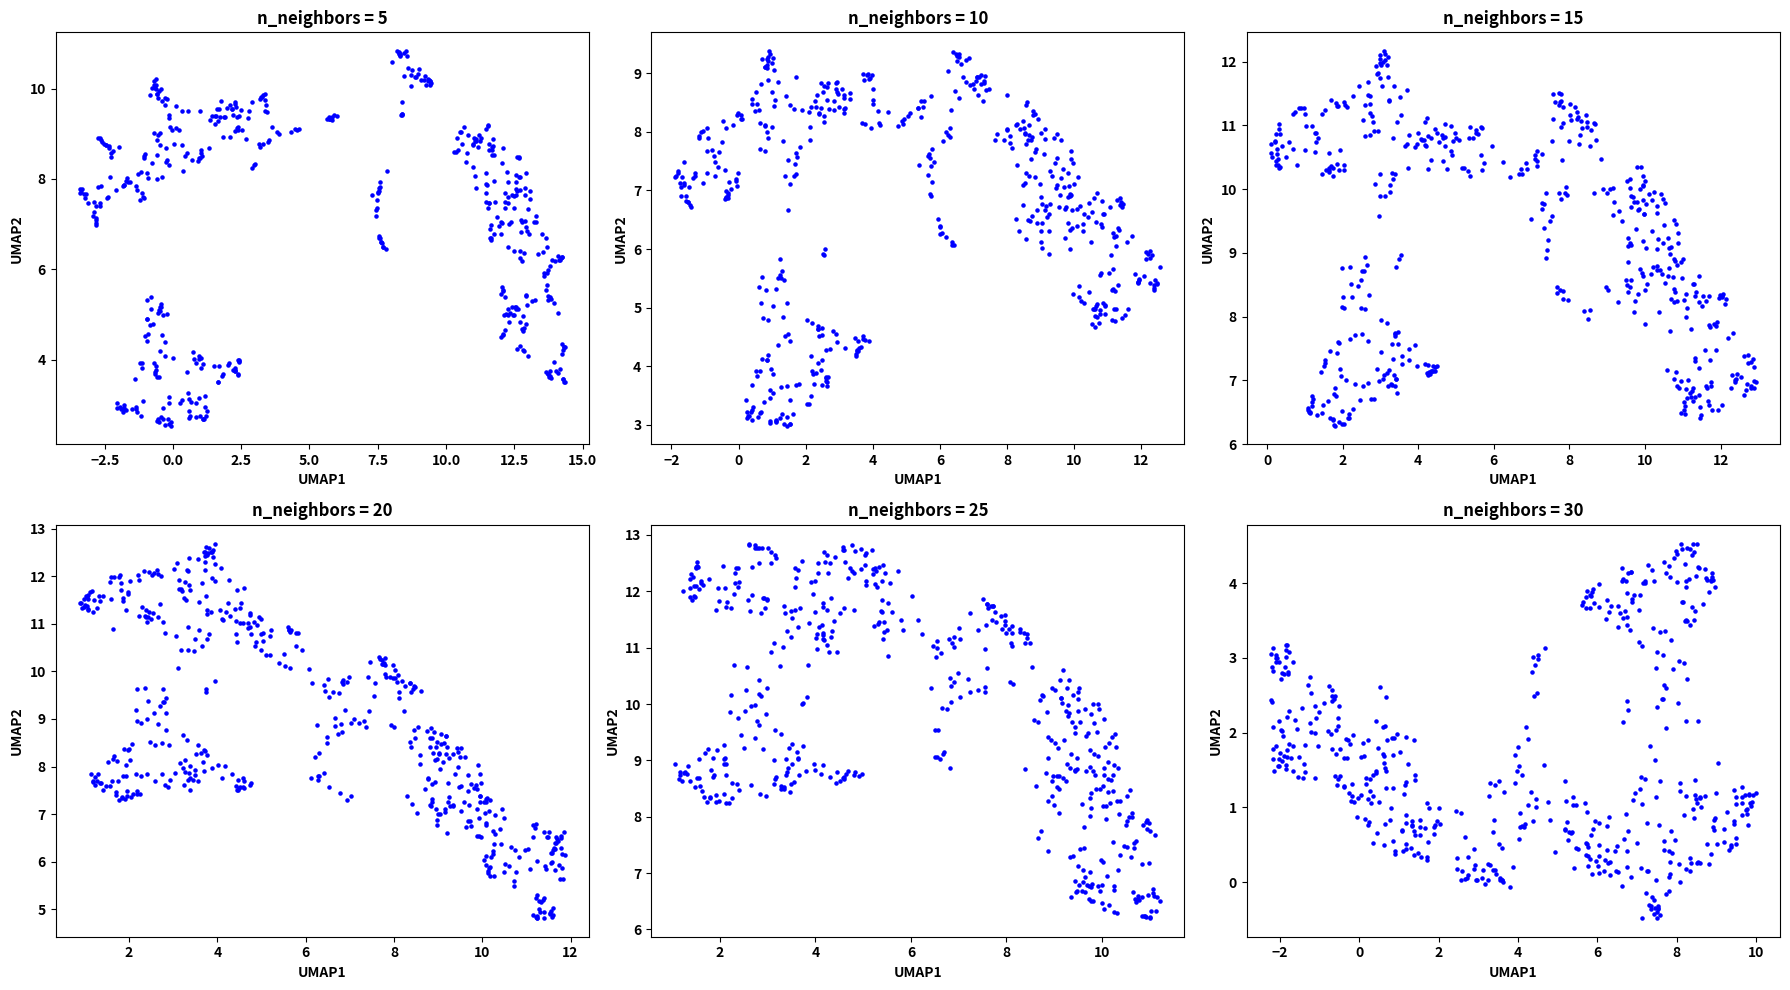

In [188]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

df = df[df["포지션"] != "GK"]
df = df[df["출전시간(분)"] > 100]
df = df[df['포지션'] != '대기']

columns_to_normalize = [
    '득점', '도움', '슈팅', '유효 슈팅', '차단된슈팅', '벗어난슈팅', 'PA내 슈팅', 'PA외 슈팅',
    '오프사이드', '프리킥', '코너킥', '스로인', '드리블 시도', '드리블 성공', '패스 시도', '패스 성공',
    '키패스', '전방 패스 시도', '전방 패스 성공', '후방 패스 시도', '후방 패스 성공', '횡패스 시도',
    '횡패스 성공', '공격지역패스 시도', '공격지역패스 성공', '수비지역패스 시도', '수비지역패스 성공',
    '중앙지역패스 시도', '중앙지역패스 성공', '롱패스 시도', '롱패스 성공', '중거리패스 시도',
    '중거리패스 성공', '숏패스 시도', '숏패스 성공', '크로스 시도', '크로스 성공', '경합 지상 시도',
    '경합 지상 성공', '경합 공중 시도', '경합 공중 성공', '태클 시도', '태클 성공', '클리어링',
    '인터셉트', '차단', '획득', '블락', '볼미스', '파울', '피파울', '경고', '퇴장'
]

for col in columns_to_normalize:
    df[col] = df[col] / (df['출전시간(분)'] / 90)


# 차원 축소를 위한 컬럼 설정
columns = [
    "선수명",
    "슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 시도", "키패스", "전방 패스 시도", "후방 패스 시도",
    "횡패스 시도",
    "공격지역패스 시도", "수비지역패스 시도",
    "중앙지역패스 시도", "롱패스 시도", "중거리패스 시도",
    "숏패스 시도", "크로스 시도"
    ,"경합 공중 시도", "태클 시도",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]


data_selecting = df[columns]
data_selected = data_selecting.iloc[:, 1:]
data_selected = data_selected.fillna(0)

# 하이퍼 파라미터 엔지니어링
num_samples = data_selected.shape[0]
n_neighbors_min = max(2, int(num_samples * 0.01))  # 데이터 포인트의 1%를 최소값으로 설정

n_neighbors_values = range(n_neighbors_min, 151, 5)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, n_neighbors in zip(axes.flatten(), n_neighbors_values):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2)
    embedding = reducer.fit_transform(data_selected)
    
    ax.scatter(embedding[:, 0], embedding[:, 1], s=5, c='blue')
    ax.set_title(f'n_neighbors = {n_neighbors}')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
print(data_selected.head())
plt.tight_layout()
plt.show()

#n_neighbors값을 16으로 채택

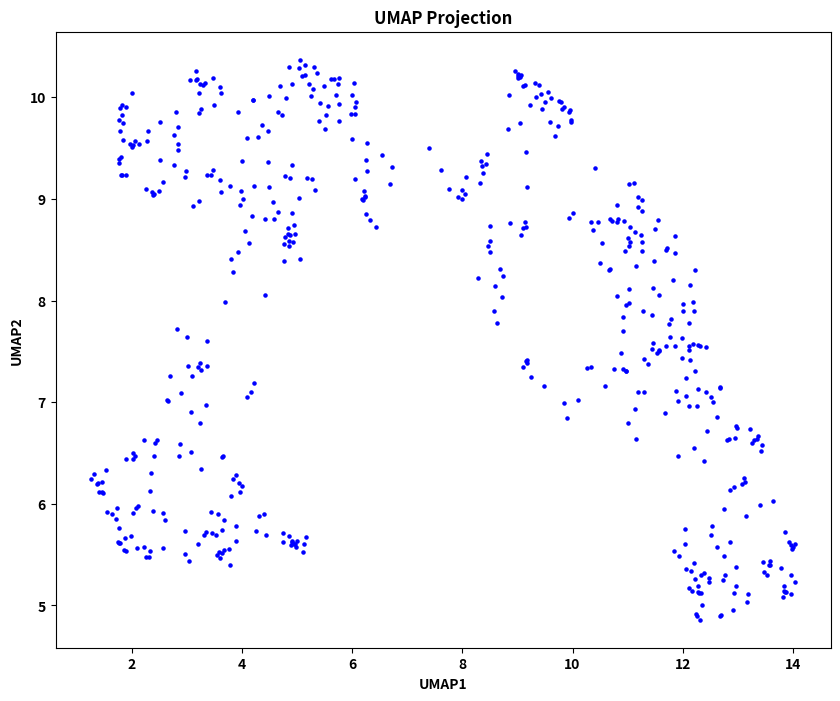

In [189]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(data_selected)
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [190]:
from sklearn.mixture import GaussianMixture

# GMM 모델 설정 및 피팅
gmm = GaussianMixture(n_components=5, random_state=82)
gmm.fit(embedding)

# 클러스터 레이블 예측
cluster_labels = gmm.predict(embedding)

# 결과를 데이터프레임에 추가 (옵션)
embedding_df['Cluster'] = cluster_labels
df = df.copy()
df.loc[:, 'Cluster'] = cluster_labels
data_selected = data_selected.copy()
data_selected.loc[:, 'Cluster'] = cluster_labels

In [191]:
# 예시: 주요 지표 비교
features = ["슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 시도", "키패스", "전방 패스 시도", "후방 패스 시도",
    "횡패스 시도",
    "공격지역패스 시도", "수비지역패스 시도",
    "중앙지역패스 시도", "롱패스 시도", "중거리패스 시도",
    "숏패스 시도", "크로스 시도", "경합 공중 시도",
    "태클 시도",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# Noto Sans CJK 폰트 파일 경로를 설정합니다
font_path = "Noto_Sans_KR/static/NotoSansKR-Bold.ttf"

# 경로에 폰트 파일이 존재하는지 확인
if os.path.isfile(font_path):
    print("폰트 파일이 존재합니다.")
else:
    print("폰트 파일을 찾을 수 없습니다.")

# 폰트를 matplotlib에 등록합니다
font_manager.fontManager.addfont(font_path)
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 폰트 이름 확인
print("설정된 폰트 이름: ", font_prop.get_name())
# 박스 플롯 예시
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()


In [193]:
# 통계적 유의성 검정
import scipy.stats as stats


def anova(frame, feat):
    for f in feat:
        # ANOVA 검정
        anova_result = stats.f_oneway(
            # frame[frame['Cluster'] == 0][f],
            # frame[frame['Cluster'] == 1][f],
            frame[frame['Cluster'] == 2][f],
            # frame[frame['Cluster'] == 3][f],
            frame[frame['Cluster'] == 4][f],
        )
        
        print(f"ANOVA F-value: {anova_result.statistic}, p-value: {anova_result.pvalue}")
        
        # p-value가 0.05보다 작으면 군집 간 차이가 유의미함을 나타냄
        if anova_result.pvalue < 0.005:
            print(f"군집 간 {f}의 차이가 통계적으로 유의합니다.")
        else:
            print(f"군집 간 {f}의 차이가 통계적으로 유의하지 않습니다.")
            
anova(df, features)


ANOVA F-value: 14.360125360616282, p-value: 0.00019557546196500043
군집 간 슈팅의 차이가 통계적으로 유의합니다.
ANOVA F-value: 16.36599139549033, p-value: 7.258979140500153e-05
군집 간 유효 슈팅의 차이가 통계적으로 유의합니다.
ANOVA F-value: 30.956480232293618, p-value: 7.730790435559987e-08
군집 간 PA내 슈팅의 차이가 통계적으로 유의합니다.
ANOVA F-value: 0.8585687638033542, p-value: 0.35516890451476424
군집 간 PA외 슈팅의 차이가 통계적으로 유의하지 않습니다.
ANOVA F-value: 10.988297423941592, p-value: 0.001074504910289188
군집 간 오프사이드의 차이가 통계적으로 유의합니다.
ANOVA F-value: 14.194549361376286, p-value: 0.0002123951642762925
군집 간 드리블 시도의 차이가 통계적으로 유의합니다.
ANOVA F-value: 4.0322344489110975, p-value: 0.04587854187563898
군집 간 키패스의 차이가 통계적으로 유의하지 않습니다.
ANOVA F-value: 176.36933919765525, p-value: 7.499250260505101e-30
군집 간 전방 패스 시도의 차이가 통계적으로 유의합니다.
ANOVA F-value: 20.568547321876416, p-value: 9.51507005703585e-06
군집 간 후방 패스 시도의 차이가 통계적으로 유의합니다.
ANOVA F-value: 162.99298455541378, p-value: 3.2707129129185625e-28
군집 간 횡패스 시도의 차이가 통계적으로 유의합니다.
ANOVA F-value: 0.1756184617318183, p-value

In [212]:
positions = ["DEFENDER", "ATACKER", "ADVANCED MIDFIELDER", "DEEP MIDFIELDER", "CENTRAL MIDFIELDER"]
df['Position'] = df['Cluster'].apply(lambda x: positions[x])
df['Second Position'] = "Null"

print(df.head())

    선수명 포지션  등번호  출전시간(분)        득점        도움        슈팅     유효 슈팅     차단된슈팅  \
0  가브리엘  FW   10     1931  0.186432  0.186432  1.631279  0.699120  0.512688   
1   갈레고  MF   11      136  0.000000  0.000000  3.308824  0.661765  1.985294   
2   강민규  MF    9     1229  0.366151  0.146461  3.075671  0.878763  0.512612   
5   강상우  DF   15     1066  0.000000  0.084428  0.590994  0.168856  0.000000   
6   강상윤  MF   77      680  0.132353  0.000000  0.794118  0.264706  0.264706   

      벗어난슈팅  ...        블락       볼미스        파울       피파울        경고   퇴장    구단  \
0  0.419472  ...  1.211807  1.258415  1.071983  2.004143  0.139824  0.0    강원   
1  0.661765  ...  1.985294  1.323529  1.323529  0.000000  0.661765  0.0    강원   
2  1.684296  ...  0.732303  1.464605  0.878763  0.292921  0.146461  0.0  충남아산   
5  0.422139  ...  1.350844  0.422139  0.253283  1.604128  0.168856  0.0    서울   
6  0.264706  ...  0.926471  0.529412  0.397059  0.926471  0.132353  0.0  수원FC   

   Cluster             Position  Secon

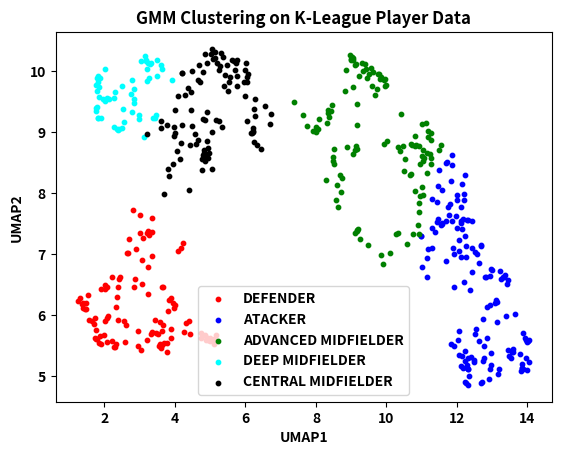

In [200]:
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']
for i in range(5):
    cluster_data = embedding_df[embedding_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=positions[i], s=10)

plt.title('GMM Clustering on K-League Player Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

# DEFENDER

통계적으로 유의미한 높은 수비 데이터 수치

---

# ATTACKER

높은 박스 내 슈팅과 공중볼 경합 시도 수치

---

# CENTRAL MIDFIELDER

전반적으로 평균적인 수치 및 높은 패스 수치

---

# ADVANCED MIDFIELDER

높은 공격 데이터 수치

---

# DEEP MIDFIELDER

압도적으로 높은 패스 수치 및 소유권 회복

---



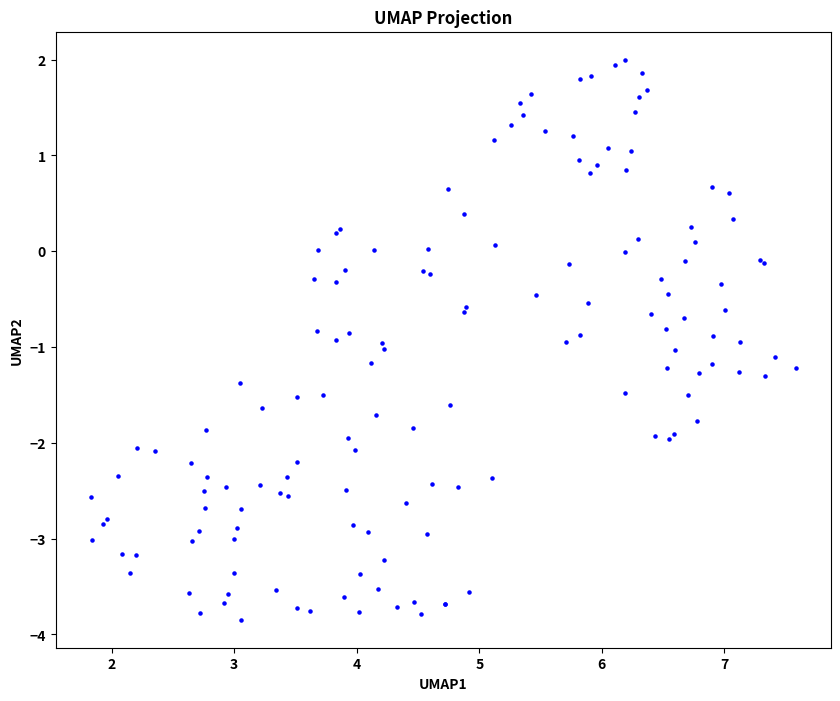

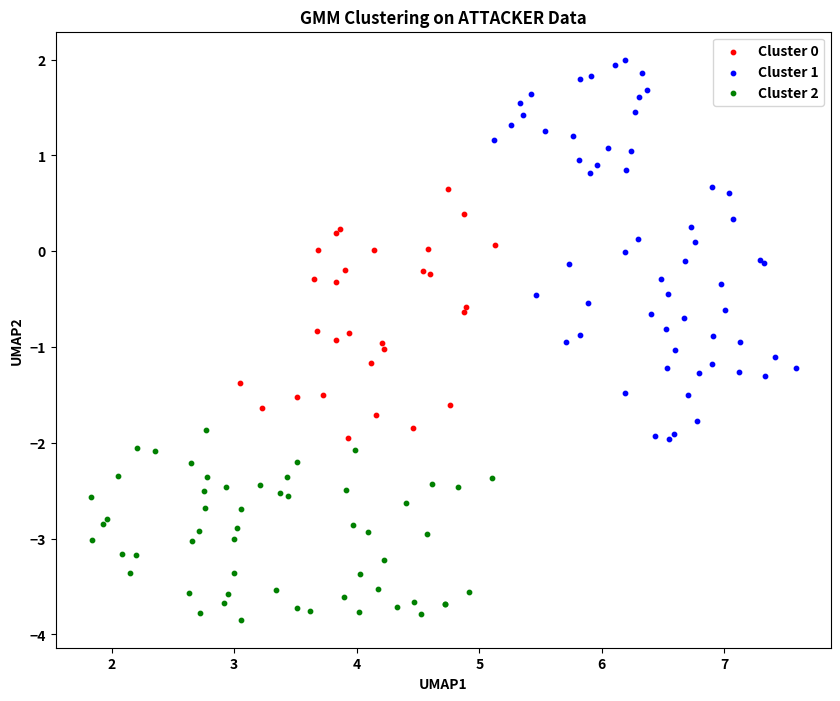

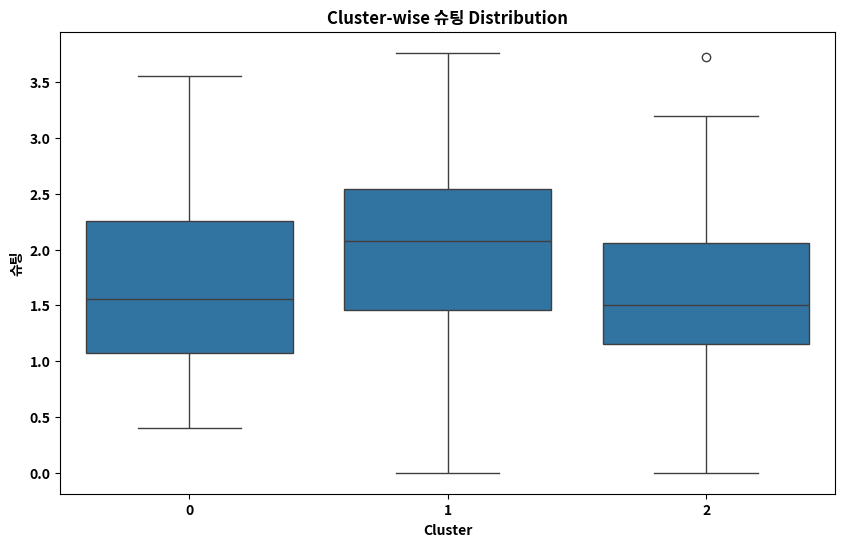

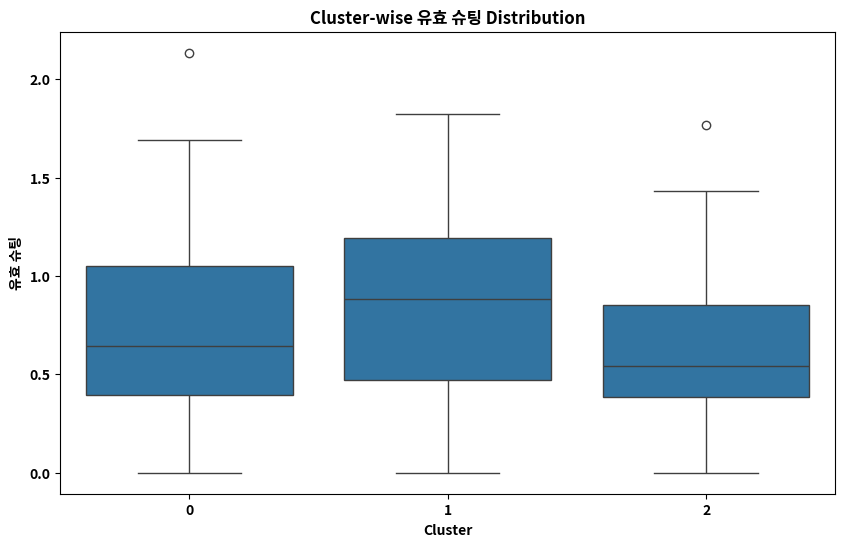

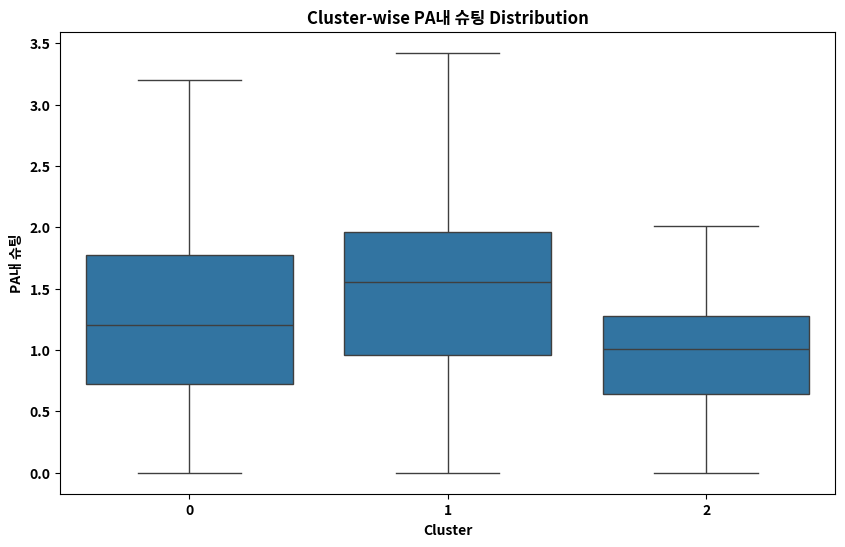

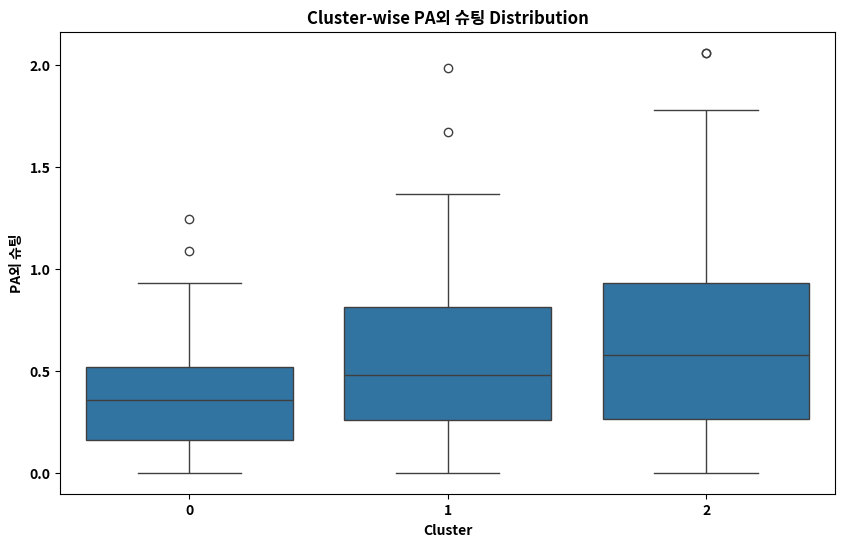

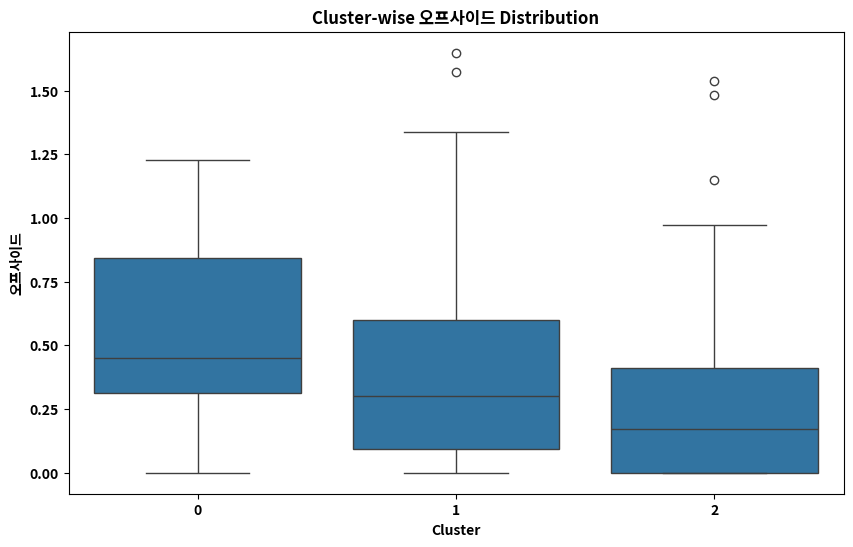

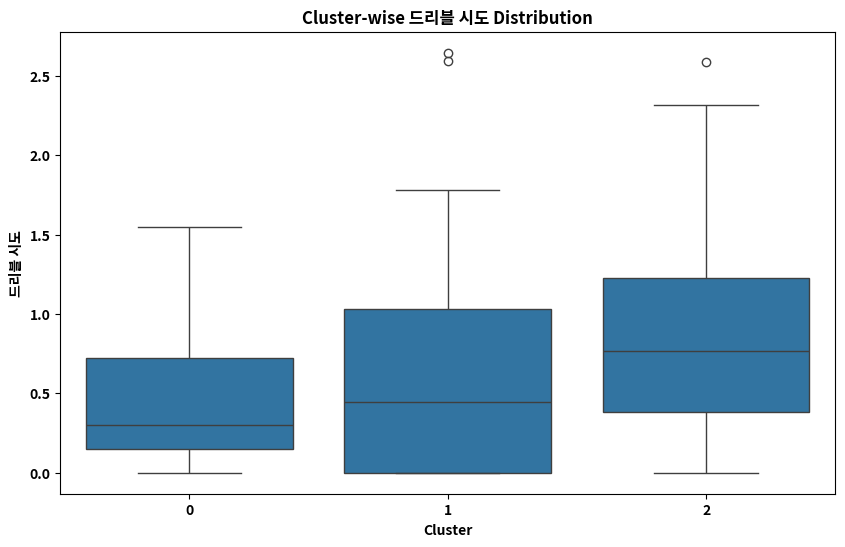

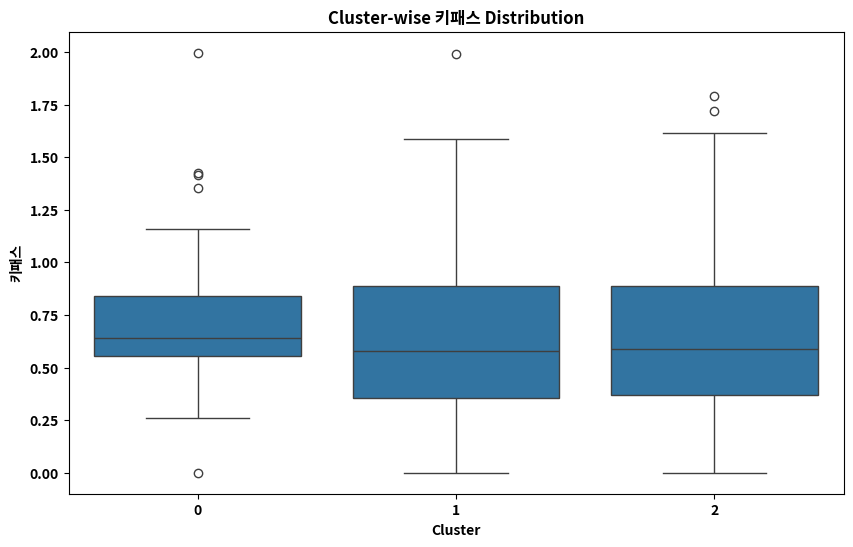

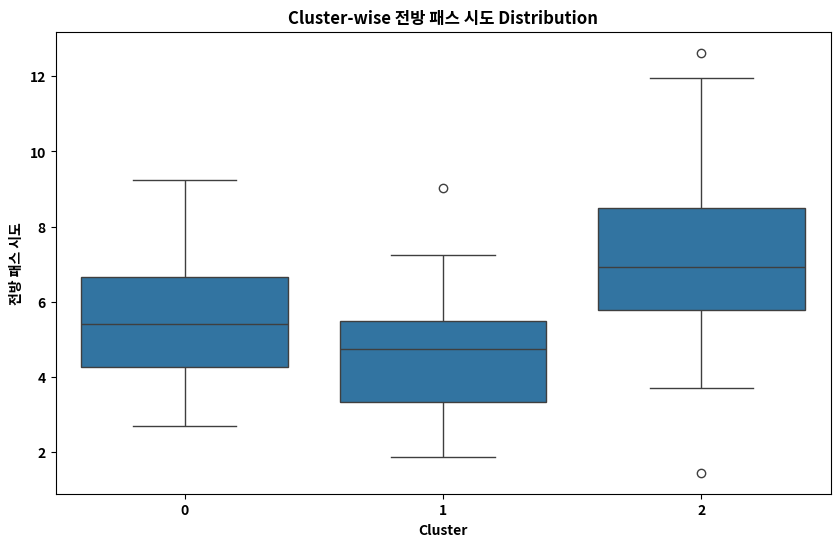

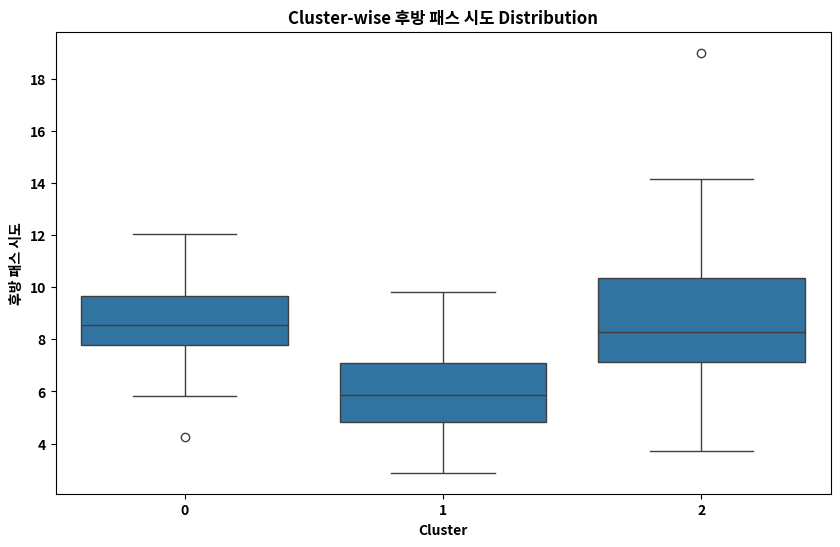

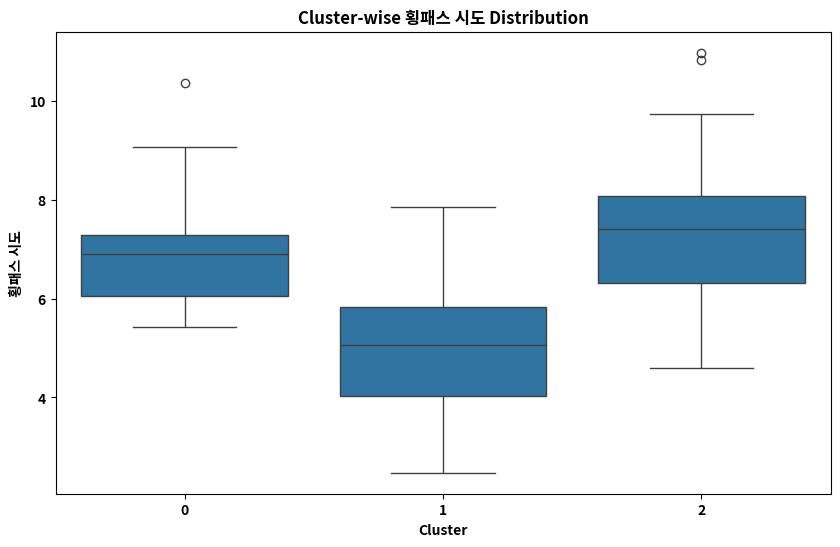

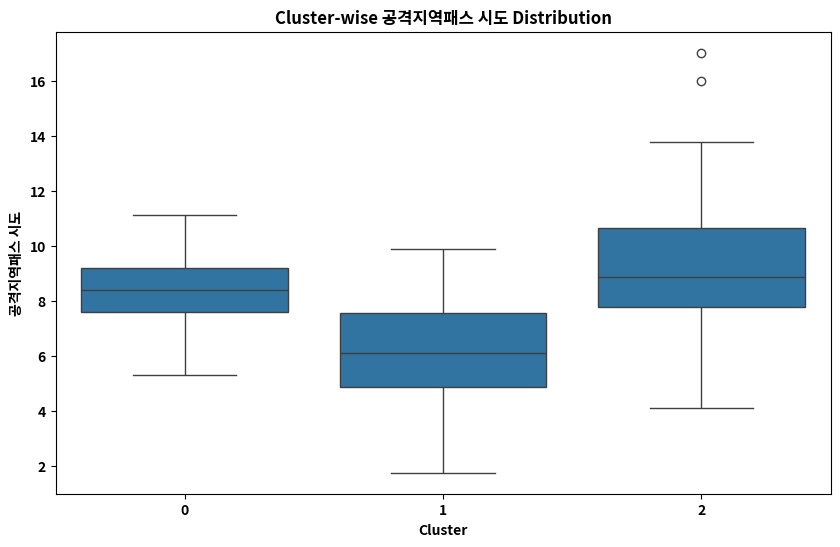

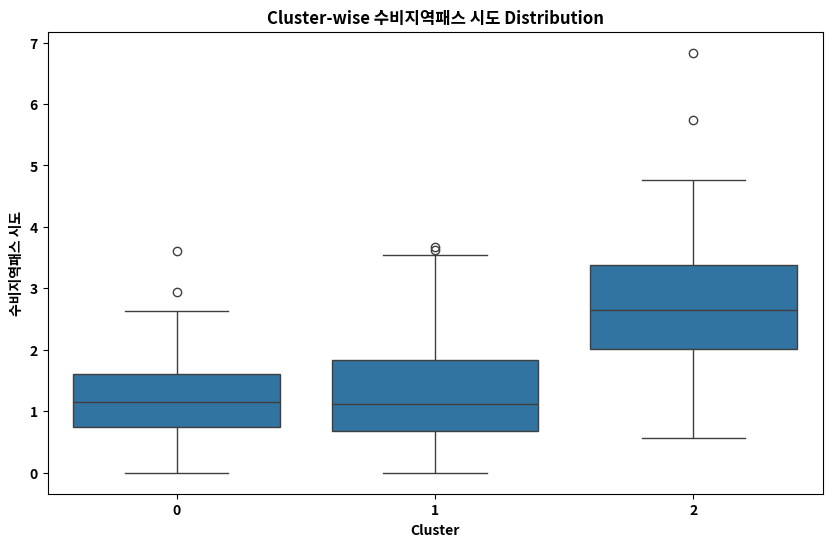

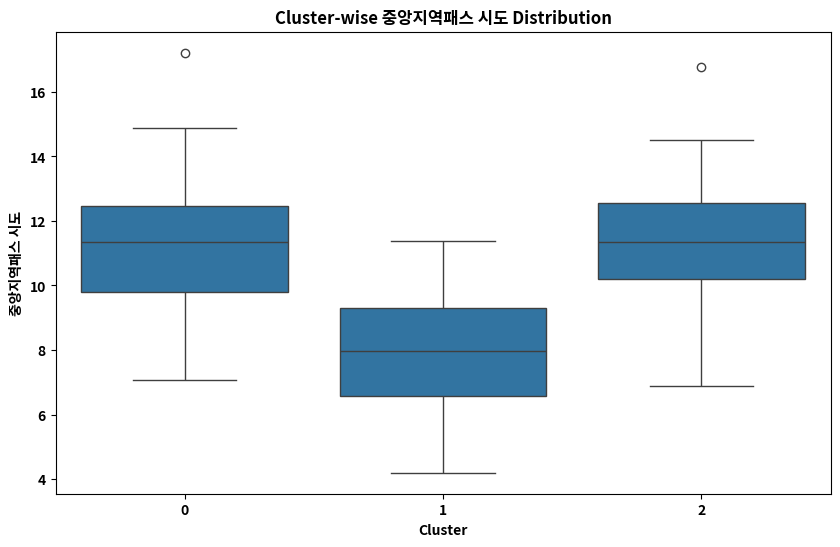

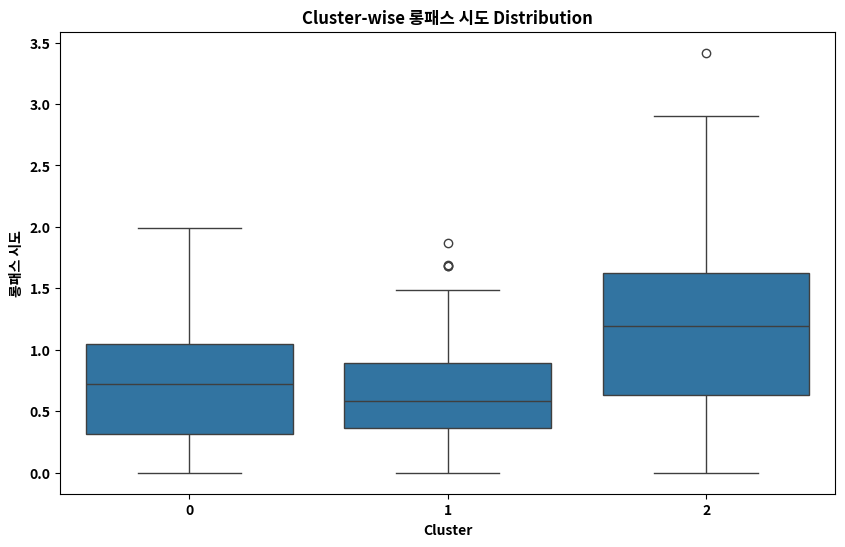

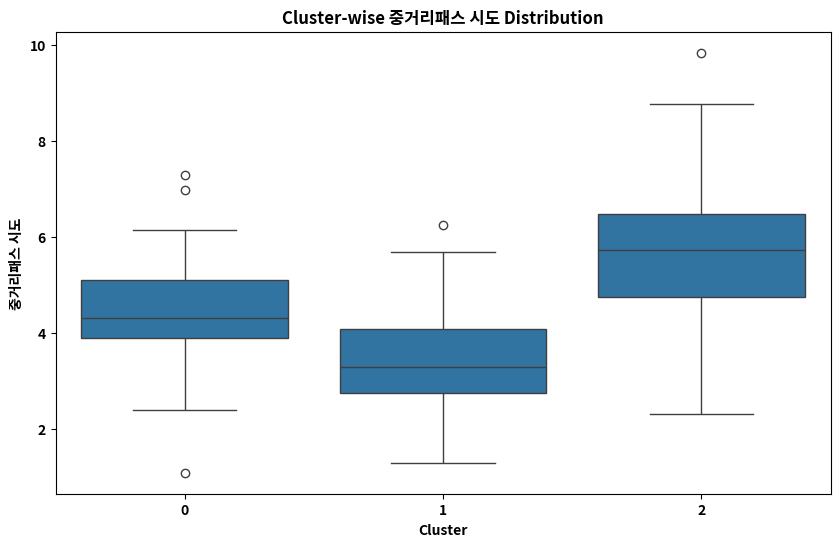

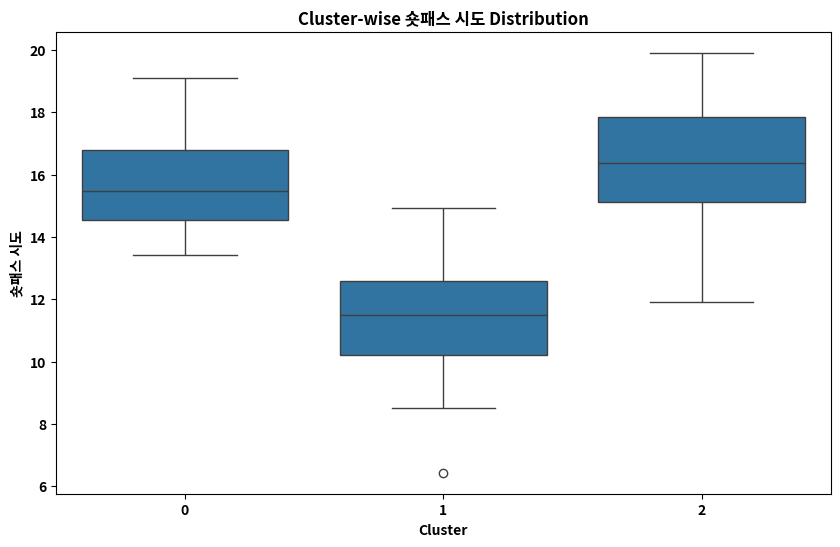

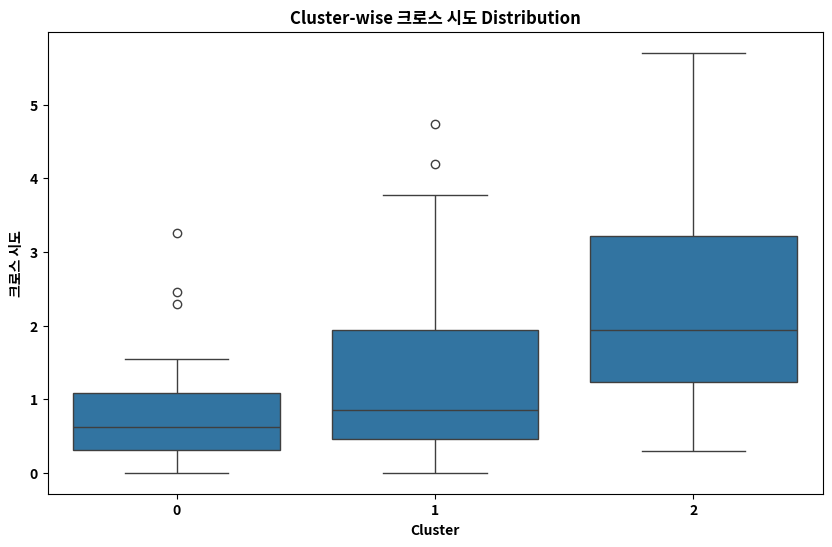

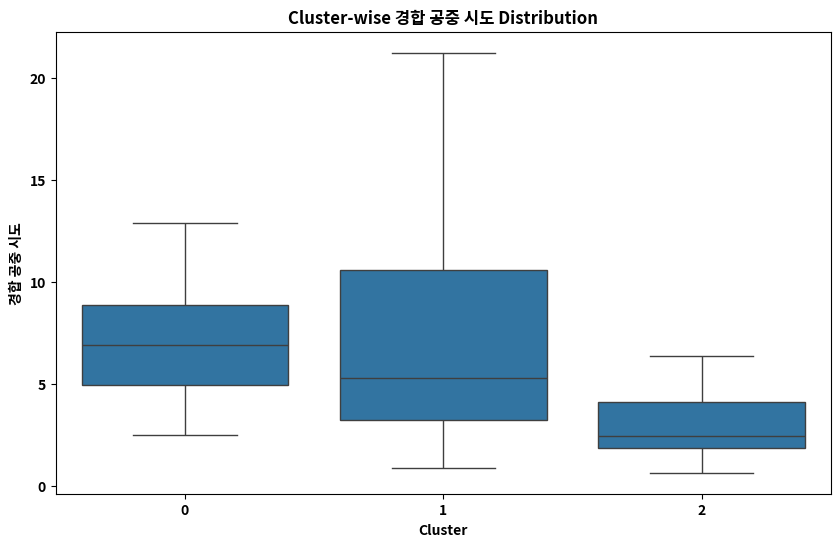

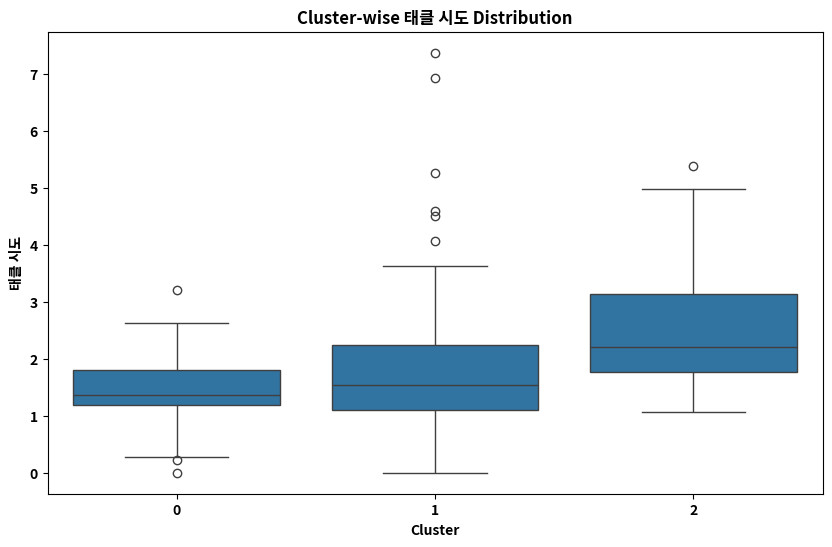

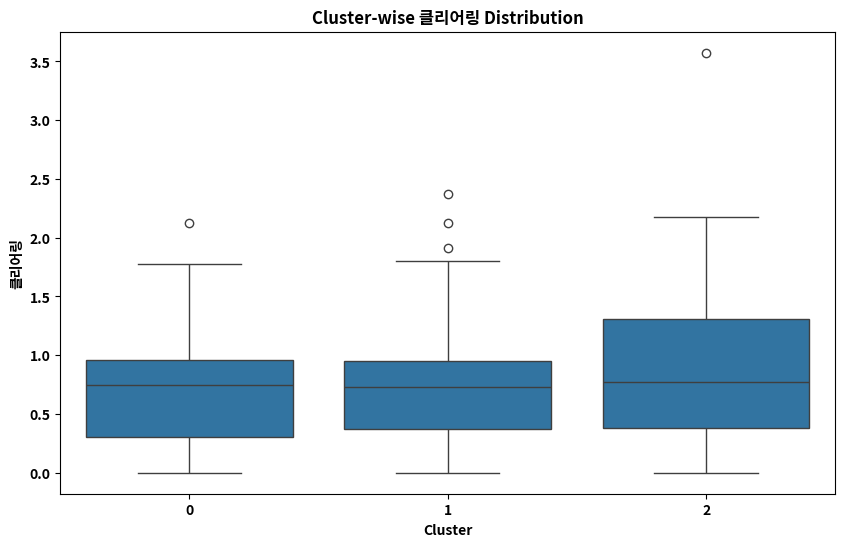

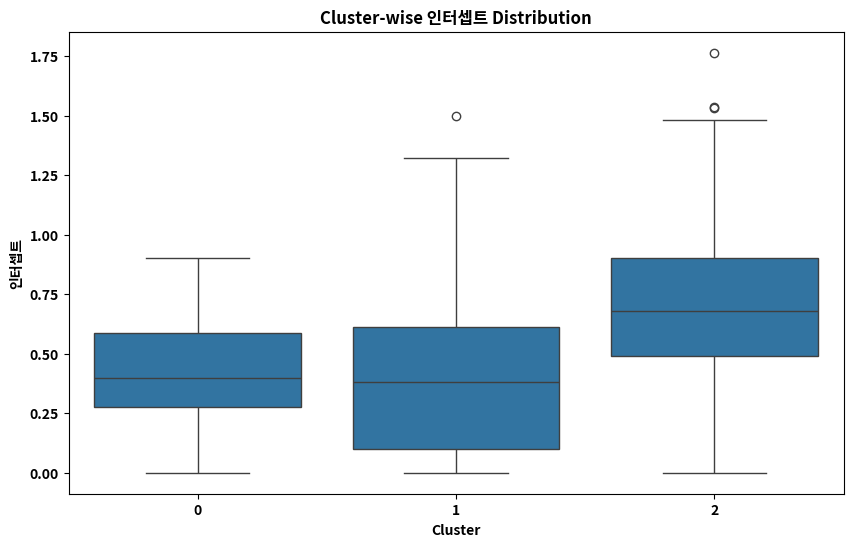

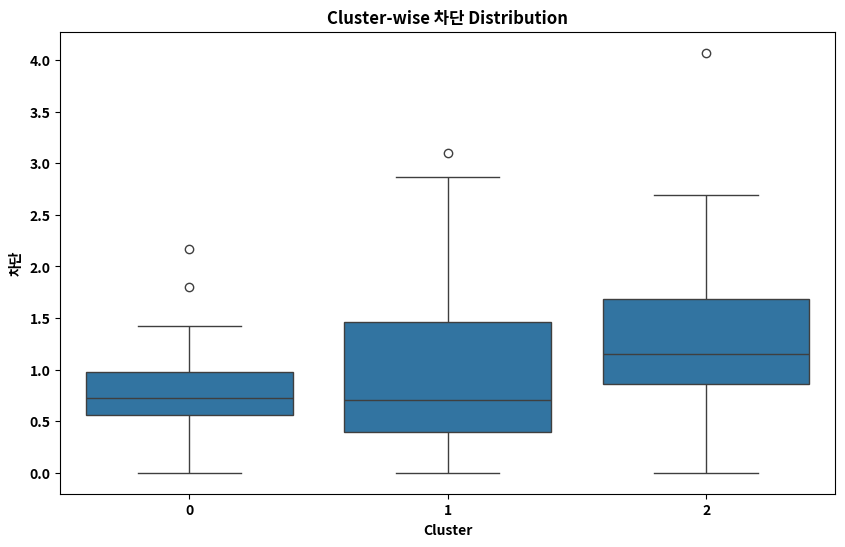

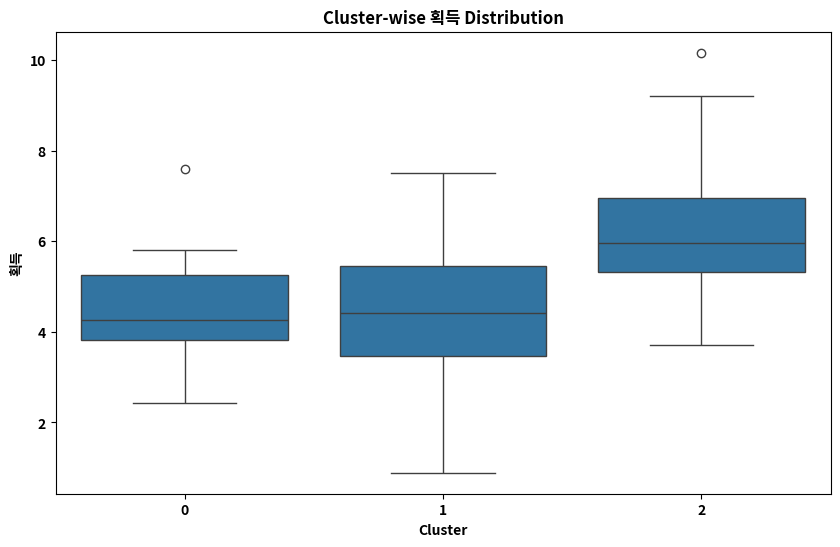

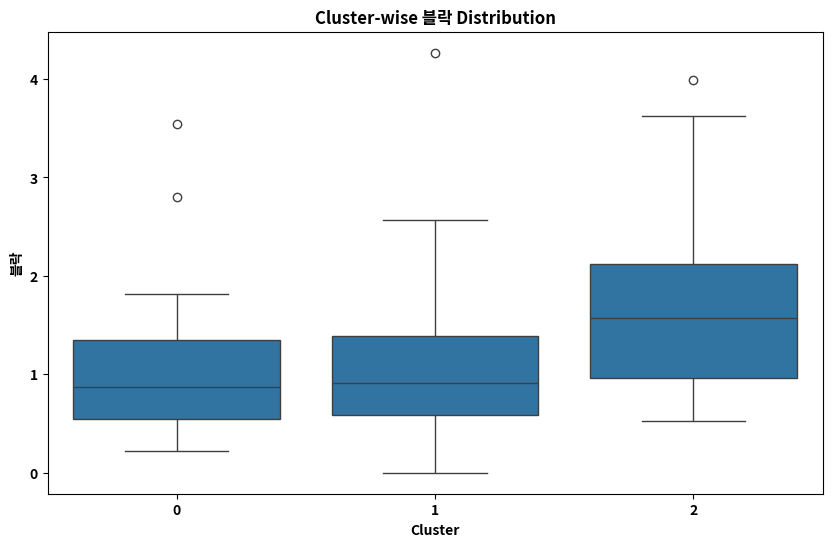

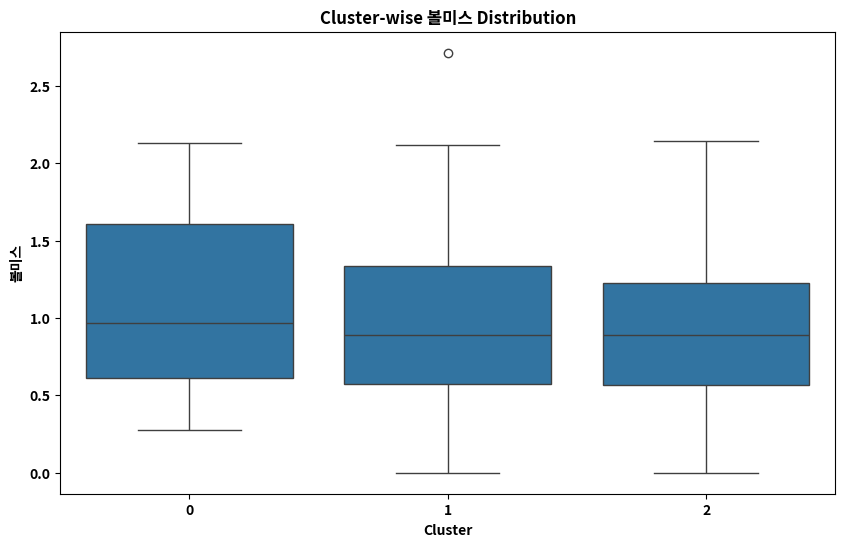

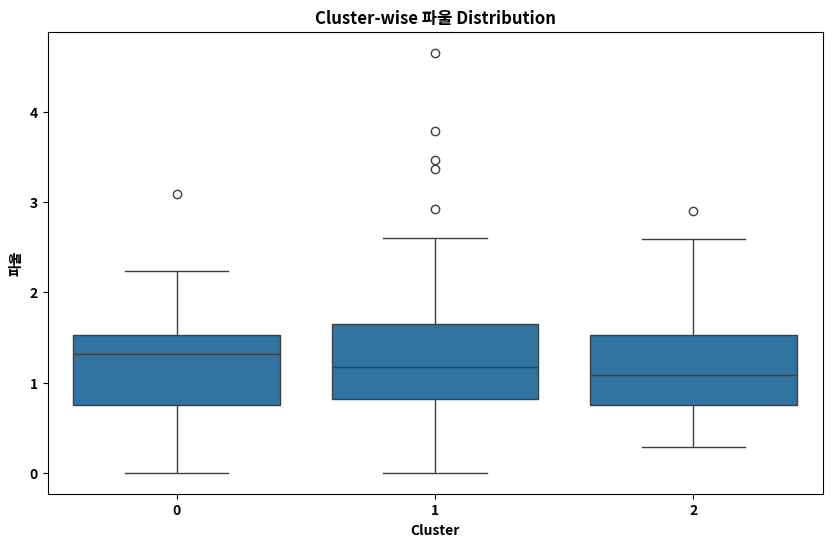

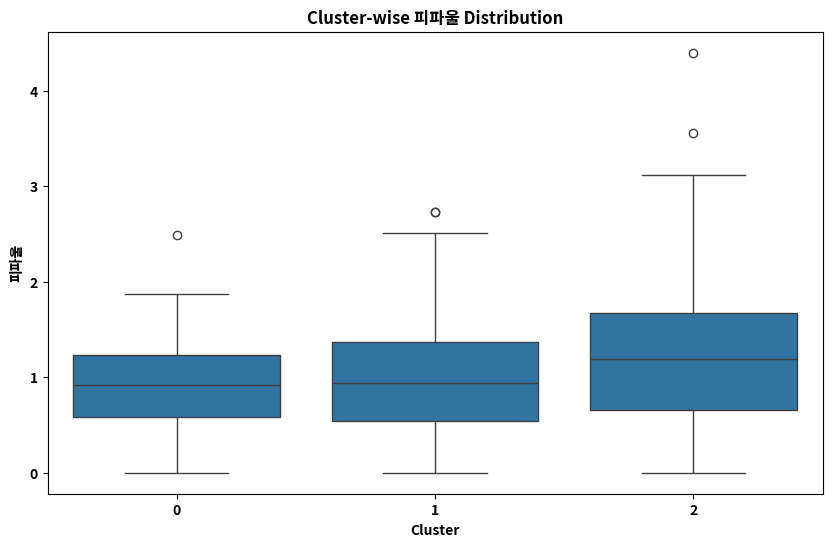

In [288]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_atk_selected = data_selected[data_selected['Cluster'] == 1]
embedding_atk = reducer.fit_transform(data_atk_selected.iloc[:, :-1])
embedding_atk_df = pd.DataFrame(embedding_atk, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding_atk[:, 0], embedding_atk[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')


plt.show()

# GaussianMixture 모델 학습
gmm_atk = GaussianMixture(n_components=3, random_state=82)
gmm_atk.fit(embedding_atk_df)

# 클러스터 레이블 예측
atk_cluster_labels = gmm_atk.predict(embedding_atk_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_atk_df = embedding_atk_df.copy()
embedding_atk_df['Cluster'] = atk_cluster_labels
data_atk_selected = data_atk_selected.copy()
data_atk_selected['Cluster'] = atk_cluster_labels


# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_data = embedding_atk_df[embedding_atk_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=f'Cluster {i}', s=10)

plt.title('GMM Clustering on ATTACKER Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_atk_selected)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()

In [289]:
atk_positions = ["ADVANCED FORWARD", "FINISHER", "WIDE ATTACKER"]
data_atk_selected['Position'] = data_atk_selected['Cluster'].apply(lambda x: atk_positions[x])
df.loc[data_atk_selected.index, 'Second Position'] = data_atk_selected['Position']

In [260]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_def_selected = data_selected[data_selected['Cluster'] == 0]
embedding_def = reducer.fit_transform(data_def_selected.iloc[:, :-1])
embedding_def_df = pd.DataFrame(embedding_def, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
# plt.figure(figsize=(10, 8))
# plt.scatter(embedding_def[:, 0], embedding_def[:, 1], s=5, c='blue')
# plt.title('UMAP Projection')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.show()

# GaussianMixture 모델 학습
gmm_def = GaussianMixture(n_components=3, random_state=82)
gmm_def.fit(embedding_def_df)

# 클러스터 레이블 예측
def_cluster_labels = gmm_def.predict(embedding_def_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_def_df = embedding_def_df.copy()
embedding_def_df['Cluster'] = def_cluster_labels
data_def_selected = data_def_selected.copy()
data_def_selected['Cluster'] = def_cluster_labels


# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

# plt.figure(figsize=(10, 8))
# for i in range(3):
#     cluster_data = embedding_def_df[embedding_def_df['Cluster'] == i]
#     plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
#                 color=colors[i], label=f'Cluster {i}', s=10)
# 
# plt.title('GMM Clustering on DEFENDER Data')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.show()
# 
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='Cluster', y=feature, data=data_def_selected)
#     plt.title(f'Cluster-wise {feature} Distribution')
#     plt.show()

In [261]:
def_positions = ["CENTER BACK", "BALL PLAYING DEFENDER", "WIDE CENTER BACK"]
data_def_selected['Position'] = data_def_selected['Cluster'].apply(lambda x: def_positions[x])
df.loc[data_def_selected.index, 'Second Position'] = data_def_selected['Position']

In [303]:
# UMAP 차원 축소
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_cm_selected = data_selected[data_selected['Cluster'] == 4]
embedding_cm = reducer.fit_transform(data_cm_selected.iloc[:, :-1])
embedding_cm_df = pd.DataFrame(embedding_cm, columns=['UMAP1', 'UMAP2'])

# GaussianMixture 모델 학습
gmm_cm = GaussianMixture(n_components=3, random_state=82)
gmm_cm.fit(embedding_cm_df)

# 클러스터 레이블 예측
cm_cluster_labels = gmm_cm.predict(embedding_cm_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_cm_df = embedding_cm_df.copy()
embedding_cm_df['Cluster'] = cm_cluster_labels
data_cm_selected = data_cm_selected.copy()
data_cm_selected['Cluster'] = cm_cluster_labels

# 새로운 포지션 값을 할당
cm_positions = ["BOX TO BOX", "DISTRIBUTOR", "DEEP LYING PLAYMAKER"]
data_cm_selected['Position'] = data_cm_selected['Cluster'].apply(lambda x: cm_positions[x])

# 원래 df에 Second Position 값을 업데이트
for idx in data_cm_selected.index:
    df.loc[idx, 'Second Position'] = data_cm_selected.loc[idx, 'Position']

# plt.figure(figsize=(10, 8))
# for i in range(3):
#     cluster_data = embedding_am_df[embedding_am_df['Cluster'] == i]
#     plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
#                 color=colors[i], label=f'Cluster {i}', s=10)
# 
# plt.title('GMM Clustering on AM Data')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.show()
# 
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='Cluster', y=feature, data=data_am_selected)
#     plt.title(f'Cluster-wise {feature} Distribution')
#     plt.show()


In [304]:
cm_positions = ["BOX TO BOX", "DISTRIBUTOR", "DEEP LYING PLAYMAKER"]
data_cm_selected['Position'] = data_cm_selected['Cluster'].apply(lambda x: cm_positions[x])
df.loc[data_cm_selected.index, 'Second Position'] = data_cm_selected['Position']

In [293]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_am_selected = data_selected[data_selected['Cluster'] == 2]
embedding_am = reducer.fit_transform(data_am_selected.iloc[:, :-1])
embedding_am_df = pd.DataFrame(embedding_am, columns=['UMAP1', 'UMAP2'])

# # 차원 축소 결과 시각화
# plt.figure(figsize=(10, 8))
# plt.scatter(embedding_am[:, 0], embedding_am[:, 1], s=5, c='blue')
# plt.title('UMAP Projection')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.show()

# GaussianMixture 모델 학습
gmm_am = GaussianMixture(n_components=3, random_state=82)
gmm_am.fit(embedding_am_df)

# 클러스터 레이블 예측
am_cluster_labels = gmm_am.predict(embedding_am_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_am_df = embedding_am_df.copy()
embedding_am_df['Cluster'] = am_cluster_labels
data_am_selected = data_am_selected.copy()
data_am_selected['Cluster'] = am_cluster_labels

# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

# plt.figure(figsize=(10, 8))
# for i in range(3):
#     cluster_data = embedding_am_df[embedding_am_df['Cluster'] == i]
#     plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
#                 color=colors[i], label=f'Cluster {i}', s=10)
# 
# plt.title('GMM Clustering on AM Data')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.show()
# 
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='Cluster', y=feature, data=data_am_selected)
#     plt.title(f'Cluster-wise {feature} Distribution')
#     plt.show()


In [294]:
am_positions = ["Box Crasher", "Creator", "Orchestrator"]
data_am_selected['Position'] = data_am_selected['Cluster'].apply(lambda x: am_positions[x])
df.loc[data_am_selected.index, 'Second Position'] = data_am_selected['Position']

In [295]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_dm_selected = data_selected[data_selected['Cluster'] == 3]
embedding_dm = reducer.fit_transform(data_dm_selected.iloc[:, :-1])
embedding_dm_df = pd.DataFrame(embedding_dm, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
# plt.figure(figsize=(10, 8))
# plt.scatter(embedding_dm[:, 0], embedding_dm[:, 1], s=5, c='blue')
# plt.title('UMAP Projection')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.show()

# GaussianMixture 모델 학습
gmm_dm = GaussianMixture(n_components=3, random_state=82)
gmm_dm.fit(embedding_dm_df)

# 클러스터 레이블 예측
dm_cluster_labels = gmm_dm.predict(embedding_dm_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_dm_df = embedding_dm_df.copy()
embedding_dm_df['Cluster'] = dm_cluster_labels
data_dm_selected = data_dm_selected.copy()
data_dm_selected['Cluster'] = dm_cluster_labels

# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

# plt.figure(figsize=(10, 8))
# for i in range(3):
#     cluster_data = embedding_dm_df[embedding_dm_df['Cluster'] == i]
#     plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
#                 color=colors[i], label=f'Cluster {i}', s=10)
# 
# plt.title('GMM Clustering on DM Data')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.show()
# 
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='Cluster', y=feature, data=data_dm_selected)
#     plt.title(f'Cluster-wise {feature} Distribution')
#     plt.show()


In [296]:
dm_positions = ["OVERLAP", "BUILDER", "WIDE"]
data_dm_selected['Position'] = data_dm_selected['Cluster'].apply(lambda x: dm_positions[x])
df.loc[data_dm_selected.index, 'Second Position'] = data_dm_selected['Position']

In [297]:
print(df.head())

    선수명 포지션  등번호  출전시간(분)        득점        도움        슈팅     유효 슈팅     차단된슈팅  \
0  가브리엘  FW   10     1931  0.186432  0.186432  1.631279  0.699120  0.512688   
1   갈레고  MF   11      136  0.000000  0.000000  3.308824  0.661765  1.985294   
2   강민규  MF    9     1229  0.366151  0.146461  3.075671  0.878763  0.512612   
5   강상우  DF   15     1066  0.000000  0.084428  0.590994  0.168856  0.000000   
6   강상윤  MF   77      680  0.132353  0.000000  0.794118  0.264706  0.264706   

      벗어난슈팅  ...        블락       볼미스        파울       피파울        경고   퇴장    구단  \
0  0.419472  ...  1.211807  1.258415  1.071983  2.004143  0.139824  0.0    강원   
1  0.661765  ...  1.985294  1.323529  1.323529  0.000000  0.661765  0.0    강원   
2  1.684296  ...  0.732303  1.464605  0.878763  0.292921  0.146461  0.0  충남아산   
5  0.422139  ...  1.350844  0.422139  0.253283  1.604128  0.168856  0.0    서울   
6  0.264706  ...  0.926471  0.529412  0.397059  0.926471  0.132353  0.0  수원FC   

   Cluster             Position  Secon

In [306]:
result_positions = def_positions + dm_positions + cm_positions + am_positions + atk_positions
print(result_positions)

['CENTER BACK', 'BALL PLAYING DEFENDER', 'WIDE CENTER BACK', 'OVERLAP', 'BUILDER', 'WIDE', 'BOX TO BOX', 'DISTRIBUTOR', 'DEEP LYING PLAYMAKER', 'Box Crasher', 'Creator', 'Orchestrator', 'ADVANCED FORWARD', 'FINISHER', 'WIDE ATTACKER']


In [310]:
result = df[df['Second Position'] == "Box Crasher"]
result_columns = ["선수명", "구단", "Position", "Second Position"]
result = result[result_columns]
print(result)

     선수명    구단             Position Second Position
7    강성진    서울  ADVANCED MIDFIELDER     Box Crasher
14   강준모    안산  ADVANCED MIDFIELDER     Box Crasher
19   강현묵    김천  ADVANCED MIDFIELDER     Box Crasher
23   고무열   서울E  ADVANCED MIDFIELDER     Box Crasher
38   국관우    성남  ADVANCED MIDFIELDER     Box Crasher
55   김규민    부천  ADVANCED MIDFIELDER     Box Crasher
81   김민우    울산  ADVANCED MIDFIELDER     Box Crasher
87   김보경    수원  ADVANCED MIDFIELDER     Box Crasher
94   김성민    인천  ADVANCED MIDFIELDER     Box Crasher
99   김승대    대전  ADVANCED MIDFIELDER     Box Crasher
183  도동현    경남  ADVANCED MIDFIELDER     Box Crasher
188  루빅손    울산  ADVANCED MIDFIELDER     Box Crasher
208  문민서    광주  ADVANCED MIDFIELDER     Box Crasher
220  바사니    부천  ADVANCED MIDFIELDER     Box Crasher
229  박민서    경남  ADVANCED MIDFIELDER     Box Crasher
241  박용희    대구  ADVANCED MIDFIELDER     Box Crasher
258  박지원    성남  ADVANCED MIDFIELDER     Box Crasher
288  변경준   서울E  ADVANCED MIDFIELDER     Box Crasher
298  서보민    

In [311]:
lingard = df[df["선수명"] == "린가드"]
print(lingard)

     선수명 포지션  등번호  출전시간(분)   득점   도움        슈팅     유효 슈팅     차단된슈팅     벗어난슈팅  \
195  린가드  FW   10      465  0.0  0.0  0.967742  0.193548  0.193548  0.580645   

     ...        블락       볼미스       파울       피파울        경고   퇴장  구단  Cluster  \
195  ...  0.774194  0.580645  1.16129  0.774194  0.580645  0.0  서울        2   

                Position  Second Position  
195  ADVANCED MIDFIELDER          Creator  

[1 rows x 76 columns]
